# Error analysis

- first group of code is just for one variable, here I do wind as an example
- second group of codes is 2D

#  Observational error for either FluxSat or Current variables
- errors from FluxSat via Shannon's simulations
- errors from current variables from publications cited in paper


In [39]:
import numpy as np
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
import xarray as xr
sys.path.append('./cerform/')
from coare3 import coare3
from air_specific_humidity import air_humidity_method_qsat26air
from surface_specific_humidity import sea_humidity_method_qsee

# chose observational error here

In [40]:
#pick one and comment out the other with #
ob_err = 'fluxsat'
#ob_err = 'current'

Cp = 1004.67         #J/K/kg specific heat at constant pressure
Rgas = 287.1

#wind = 7.00000          #m/s    average wind speed over ocean
Tsea = 289.25         #K      average SST over ocean
Tair = Tsea-1.3        #K      average surface air temperature over ocean
Tsea_degC = Tsea - 273.15
Tair_degC = Tair - 273.15
rel_hum = 0.80000       #N/A    near surface relative humidity
pres = 1013.00000       #mb     average surface pressure used in Bentamy

#calculate Qsea and Qair from Tsea, pres, Tair, rel_hum from coare
Lv = (2.501-0.00237*Tsea)*1e6 #J/kg   latent heat of vaporization  SB had 2500000 CG changed to coare3 def
sat_vap_pres =  6.1121*np.exp(17.502*Tair_degC/(Tair_degC+240.97))*(1.0007+3.46e-6*pres) #from coare3
Qsea = sea_humidity_method_qsee(Tsea_degC,pres)/1000
Qair = air_humidity_method_qsat26air(Tair_degC,pres,rel_hum*100)/1000
air_density = pres*100./(Rgas*(Tair)*(1.+0.61*Qair))

if ob_err == 'fluxsat':
    dTsea = 0.45  #check with shannon for more recent estimates for these values
    dwind = 0.6
    dTair = 0.7
    dQair = .95
    dQair_computed = Qair * 0.07 #percent from shannon
    dpres = 5
if ob_err == 'current':
    dTsea = 0.5 #ref found
    dwind = 0.8 #ref found
    dTair = 1.42
    dQair = 1.25
    dQair_computed = 1.25/1000.
    dpres = 5

    

# 1D errors

In [41]:
data = np.zeros(30)*np.nan
tem =xr.DataArray(data,dims=('wind'),coords={'wind':np.arange(0,30)})
save_errors = xr.Dataset({'lhf_rand':tem,'shf_rand':tem, 'lhf_perror':tem,'shf_perror':tem})
ss,sl,xx=[],[],[]

for wind in range(0,30):
    xx.append(wind)
    #variable	value	units	notes

    dpres_computed = (pres+dpres)*100 / (287*Tair) - air_density
    #print('Qair error:', dQair_computed*1000)

    #compute Qsea errors from coare3 using uncertainty in SST & pres
    Qsea0 = sea_humidity_method_qsee(Tsea_degC,pres)
    Qsea1 = sea_humidity_method_qsee(Tsea_degC+dTsea,pres)
    Qsea2 = sea_humidity_method_qsee(Tsea_degC-dTsea,pres)
    Qsea_dTsea = (np.maximum(np.abs(Qsea0-Qsea2),np.abs(Qsea0-Qsea1)))
    Qsea0 = sea_humidity_method_qsee(Tsea_degC,pres)
    Qsea1 = sea_humidity_method_qsee(Tsea_degC,pres+dpres)
    Qsea2 = sea_humidity_method_qsee(Tsea_degC,pres-dpres)
    Qsea_dpres = (np.maximum(np.abs(Qsea0-Qsea2),np.abs(Qsea0-Qsea1)))
    dQsea_computed = np.sqrt(Qsea_dTsea**2+Qsea_dpres**2)/1000
    #print('Qsea and Qsea uncertainty:',Qsea*1000,dQsea_computed*1000)
    
    
    # calculate Ch and Ce using coare
    inputs = {'u':wind,'t':Tair_degC,'Q':Qair*1000,'Qs':Qsea*1000,'P':pres,'ts':Tsea_degC,'lat':35.}
    res = coare3(inputs)
    Ch = res['Ch']
    Ce = res['Ce']
    #print(Ch,Ce)
    dLH_over_dqs =   air_density * Ce * wind * Lv               * dQsea_computed
    dLH_over_dqair = air_density * Ce * wind * Lv               * dQair_computed
    dLH_over_dwind = air_density * Ce *        Lv * (Qsea-Qair) * dwind
    dLH_over_dpres =               Ce * wind * Lv * (Qsea-Qair) * dpres_computed

    total_error = np.sqrt(dLH_over_dqs**2+
                          dLH_over_dqair**2+
                          dLH_over_dwind**2+
                          dLH_over_dpres**2)

    signal = air_density * Lv * Ce * (Qsea-Qair) * wind

    percent_error = total_error / signal *100

    # print('dLH_over_dqs',dLH_over_dqs)
    # print('dLH_over_dqair',dLH_over_dqair)
    # print('dLH_over_dwind',dLH_over_dwind)
    # print('dLH_over_dpres',dLH_over_dpres)
    #print('Latent Heat Flux total_error',total_error)
    #print('signal',signal)
    #print('percent error',percent_error)

    latent_heat_flux_total_error = total_error
    
    dSH_over_dTsea = air_density * Cp * Ch * wind               * dTsea
    dSH_over_dTair = air_density * Cp * Ch * wind               * dTair
    dSH_over_dwind = air_density * Cp * Ch        * (Tsea-Tair) * dwind
    dSH_over_dpres =               Cp * Ch * wind * (Tsea-Tair) * dpres_computed

    total_error = np.sqrt(dSH_over_dTsea**2+
                          dSH_over_dTair**2+
                          dSH_over_dwind**2+
                          dSH_over_dpres**2)

    signal = air_density * Cp * Ch * (Tsea-Tair) * wind

    percent_error = total_error / signal *100

    #print('dSH_over_dTsea',dSH_over_dTsea)
    #print('dSH_over_dTair',dSH_over_dTair)
    #print('dSH_over_dwind',dSH_over_dwind)
    #print('dSH_over_dpres',dSH_over_dpres)
    #print('Sensible Heat Flux total_error',total_error)
    #print('signal',signal)
    #print('percent error',percent_error)

    sensible_heat_flux_total_error = total_error
    
    ss.append(sensible_heat_flux_total_error.data[0])
    sl.append(latent_heat_flux_total_error.data[0])

save_errors['lhf_rand']=xr.DataArray(sl,dims=('wind'),coords={'wind':xx})
save_errors['shf_rand']=xr.DataArray(ss,dims=('wind'),coords={'wind':xx})

# plot errors

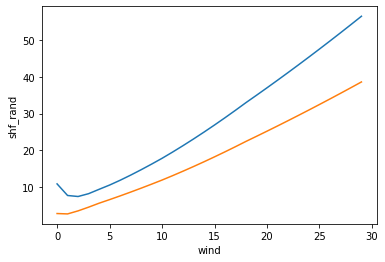

In [42]:
save_errors.lhf_rand.plot()
save_errors.shf_rand.plot()

# 2D delta Tair and wind

In [138]:
ss2,sl2,ps2, pl2, tt = np.zeros((60,30))*np.nan,np.zeros((60,30))*np.nan,np.zeros((60,30))*np.nan,np.zeros((60,30))*np.nan,[]
for iair,Tair_offset in enumerate(np.arange(-15.0,15.0,0.5)):
    tt.append(Tair_offset)
    ss,sl,xx,ps,pl=[],[],[],[],[]
    for wind in range(0,30):
        xx.append(wind)
        #variable	value	units	notes

        #wind = 7.00000          #m/s    average wind speed over ocean
        Tair = Tsea-Tair_offset        #K      average surface air temperature over ocean
        Tsea_degC = Tsea - 273.15
        Tair_degC = Tair - 273.15

        #calculate Qsea and Qair from Tsea, pres, Tair, rel_hum from coare
        Lv = (2.501-0.00237*Tsea)*1e6 #J/kg   latent heat of vaporization  SB had 2500000 CG changed to coare3 def
        sat_vap_pres =  6.1121*np.exp(17.502*Tair_degC/(Tair_degC+240.97))*(1.0007+3.46e-6*pres) #from coare3
        Qsea = sea_humidity_method_qsee(Tsea_degC,pres)/1000
        Qair = air_humidity_method_qsat26air(Tair_degC,pres,rel_hum*100)/1000
        air_density = pres*100./(Rgas*(Tair)*(1.+0.61*Qair))

        dpres_computed = (pres+dpres)*100 / (287*Tair) - air_density
        #print('Qair error:', dQair_computed*1000)

        #compute Qsea errors from coare3 using uncertainty in SST & pres
        Qsea0 = sea_humidity_method_qsee(Tsea_degC,pres)
        Qsea1 = sea_humidity_method_qsee(Tsea_degC+dTsea,pres)
        Qsea2 = sea_humidity_method_qsee(Tsea_degC-dTsea,pres)
        Qsea_dTsea = (np.maximum(np.abs(Qsea0-Qsea2),np.abs(Qsea0-Qsea1)))
        Qsea0 = sea_humidity_method_qsee(Tsea_degC,pres)
        Qsea1 = sea_humidity_method_qsee(Tsea_degC,pres+dpres)
        Qsea2 = sea_humidity_method_qsee(Tsea_degC,pres-dpres)
        Qsea_dpres = (np.maximum(np.abs(Qsea0-Qsea2),np.abs(Qsea0-Qsea1)))
        dQsea_computed = np.sqrt(Qsea_dTsea**2+Qsea_dpres**2)/1000
        #print('Qsea and Qsea uncertainty:',Qsea*1000,dQsea_computed*1000)

        # calculate Ch and Ce using coare
        inputs = {'u':wind,'t':Tair_degC,'Q':Qair*1000,'Qs':Qsea*1000,'P':pres,'ts':Tsea_degC,'lat':35.}
        res = coare3(inputs)
        Ch = res['Ch']
        Ce = res['Ce']
        #print(Ch,Ce)
        dLH_over_dqs =   air_density * Ce * wind * Lv               * dQsea_computed
        dLH_over_dqair = air_density * Ce * wind * Lv               * dQair_computed
        dLH_over_dwind = air_density * Ce *        Lv * (Qsea-Qair) * dwind
        dLH_over_dpres =               Ce * wind * Lv * (Qsea-Qair) * dpres_computed

        # modified to be the total error per g/kg air/sea moisture difference
        total_error = np.sqrt(dLH_over_dqs**2+
                              dLH_over_dqair**2+
                              dLH_over_dwind**2+
                              dLH_over_dpres**2) 
        
        signal = air_density * Lv * Ce * (Qsea-Qair) * wind 

        percent_error_lhf = abs( total_error / signal *100 )

        # print('dLH_over_dqs',dLH_over_dqs)
        # print('dLH_over_dqair',dLH_over_dqair)
        # print('dLH_over_dwind',dLH_over_dwind)
        # print('dLH_over_dpres',dLH_over_dpres)
        #print('Latent Heat Flux total_error',total_error)
        #print('signal',signal)
        #print('percent error',percent_error)

        # modified to be the total error per g/kg air/sea moisture difference
        latent_heat_flux_total_error = total_error 

        dSH_over_dTsea = air_density * Cp * Ch * wind               * dTsea
        dSH_over_dTair = air_density * Cp * Ch * wind               * dTair
        dSH_over_dwind = air_density * Cp * Ch        * (Tsea-Tair) * dwind
        dSH_over_dpres =               Cp * Ch * wind * (Tsea-Tair) * dpres_computed
        
        total_error = np.sqrt(dSH_over_dTsea**2+
                              dSH_over_dTair**2+
                              dSH_over_dwind**2+
                              dSH_over_dpres**2)

        signal = air_density * Cp * Ch * (Tsea-Tair) * wind

        percent_error_shf = abs( total_error / signal *100 )

        #print('dSH_over_dTsea',dSH_over_dTsea)
        #print('dSH_over_dTair',dSH_over_dTair)
        #print('dSH_over_dwind',dSH_over_dwind)
        #print('dSH_over_dpres',dSH_over_dpres)Fss
        #print('Sensible Heat Flux total_error',total_error)
        #print('signal',signal)
        #print('percent error',percent_error)

        sensible_heat_flux_total_error = total_error

        ss.append(sensible_heat_flux_total_error.data[0])
        sl.append(latent_heat_flux_total_error.data[0])
        ps.append(percent_error_shf.data[0])
        pl.append(percent_error_lhf.data[0])

    ss2[iair,:]=ss
    sl2[iair,:]=sl
    ps2[iair,:]=ps
    pl2[iair,:]=pl

save_errors['shf_rand']=xr.DataArray(ss2,dims=('deltaT','wind'),coords={'deltaT':tt,'wind':xx})
save_errors['lhf_rand']=xr.DataArray(sl2,dims=('deltaT','wind'),coords={'deltaT':tt,'wind':xx})
save_errors['shf_perror']=xr.DataArray(ss2,dims=('deltaT','wind'),coords={'deltaT':tt,'wind':xx})
save_errors['lhf_perror']=xr.DataArray(sl2,dims=('deltaT','wind'),coords={'deltaT':tt,'wind':xx})

<ipython-input-139-5fd8b7f55cfa>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, tt, ss2)
<ipython-input-139-5fd8b7f55cfa>:17: UserWarning: The following kwargs were not used by contour: 'shading'
  plt.contourf(xx,tt, ss2, r_levels, shading='auto' )


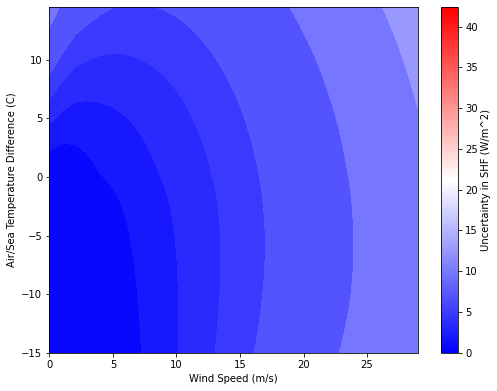

In [139]:

fig = plt.figure(num=None, figsize=(8,6))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 
ax.set_ylabel("Air/Sea Temperature Difference (C)")
ax.set_xlabel("Wind Speed (m/s)")

#x,y = np.meshgrid(np.arange(31), np.arange(51))
r_levels = [0, 5, 10, 15, 20, 30, 40, 50, 75, 100, 150]
p_levels = [0, 5, 10, 15, 20, 30, 40, 50, 75, 100, 150]

plt.pcolormesh(xx, tt, ss2)
cbar = plt.colorbar()
plt.set_cmap('bwr') 
cbar.set_label('Uncertainty in SHF (W/m^2)', labelpad = 2.5)

# range of xx should be 0:11 and range of tt should be 20:40
plt.contourf(xx,tt, ss2, r_levels, shading='auto' )
plt.show()
plt.savefig('SHF Uncertainty.png')
plt.close()

<ipython-input-140-3b050e79d37d>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, tt, sl2)
<ipython-input-140-3b050e79d37d>:17: UserWarning: The following kwargs were not used by contour: 'shading'
  plt.contourf(xx,tt, ss2, r_levels, shading='auto' )


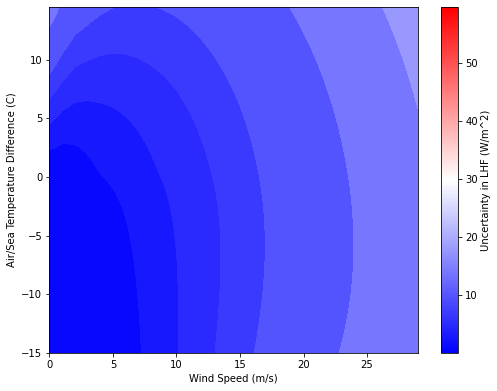

In [140]:
fig = plt.figure(num=None, figsize=(8,6))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 
ax.set_ylabel("Air/Sea Temperature Difference (C)")
ax.set_xlabel("Wind Speed (m/s)")

#x,y = np.meshgrid(np.arange(31), np.arange(51))
r_levels = [0, 5, 10, 15, 20, 30, 40, 50, 75, 100, 150]
p_levels = [0, 5, 10, 15, 20, 30, 40, 50, 75, 100, 150]

plt.pcolormesh(xx, tt, sl2)
cbar = plt.colorbar()  # I am worried that this is not using the correct levels
#plt.set_cmap('bwr') 
cbar.set_label('Uncertainty in LHF (W/m^2)', labelpad = 2.5)

# range of xx should be 0:11 and range of tt should be 20:40
plt.contourf(xx,tt, ss2, r_levels, shading='auto' ) 
plt.show()
plt.savefig('LHF Uncertainty.png')
plt.close()

<ipython-input-141-8193644cf5b3>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, tt, ps2)
<ipython-input-141-8193644cf5b3>:17: UserWarning: The following kwargs were not used by contour: 'shading'
  plt.contourf(xx,tt, ps2, p_levels, shading='auto' )


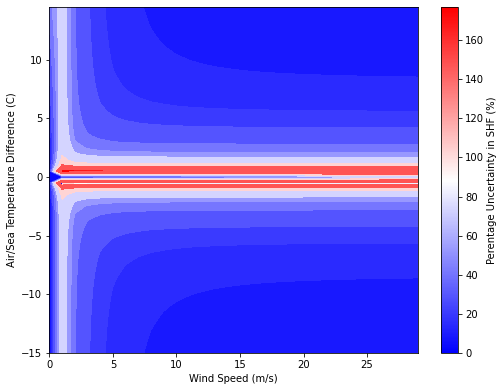

In [141]:
fig = plt.figure(num=None, figsize=(8,6))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 
ax.set_ylabel("Air/Sea Temperature Difference (C)")
ax.set_xlabel("Wind Speed (m/s)")

#x,y = np.meshgrid(np.arange(31), np.arange(51))
r_levels = [0, 5, 10, 15, 20, 30, 40, 50, 75, 100, 150]
p_levels = [0, 5, 10, 15, 20, 30, 40, 50, 75, 100, 150]

plt.pcolormesh(xx, tt, ps2)
cbar = plt.colorbar()
#plt.set_cmap('bwr') 
cbar.set_label('Perentage Uncertainty in SHF (%)', labelpad = 2.5)

#trim to <=10 m/s and 5 to 15 degrees
plt.contourf(xx,tt, ps2, p_levels, shading='auto' ) 
plt.show()
plt.savefig('LHF Percent Uncertainty.png')
plt.close()

<ipython-input-143-0f96188e6012>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, tt, pl2)
<ipython-input-143-0f96188e6012>:17: UserWarning: The following kwargs were not used by contour: 'shading'
  plt.contourf(xx,tt, pl2, p_levels, shading='auto' )


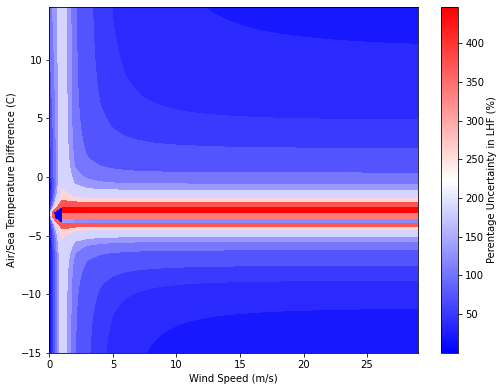

In [143]:
fig = plt.figure(num=None, figsize=(8,6))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 
ax.set_ylabel("Air/Sea Temperature Difference (C)")
ax.set_xlabel("Wind Speed (m/s)")

#x,y = np.meshgrid(np.arange(31), np.arange(51))
r_levels = [0, 5, 10, 15, 20, 30, 40, 50, 75, 100, 150]
p_levels = [0, 5, 10, 15, 20, 30, 40, 50, 75, 100, 150]

plt.pcolormesh(xx, tt, pl2)
cbar = plt.colorbar()
#plt.set_cmap('bwr') 
cbar.set_label('Perentage Uncertainty in LHF (%)', labelpad = 2.5)

#trim to <=10 m/s and 5 to 15 degrees
plt.contourf(xx,tt, pl2, p_levels, shading='auto' ) 
plt.show()
plt.savefig('LHF Uncertainty.png')
plt.close()

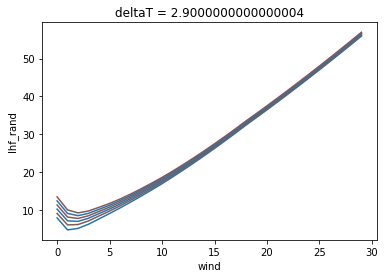

In [142]:
for i in range(30):
    save_errors.lhf_rand.isel(deltaT=i).plot()

In [ ]:
for i in range(30):
    save_errors.shf_rand.isel(deltaT=i).plot()